In [9]:
import numpy as np
from scipy.interpolate import interp1d

def matvec(A,B,C,x):
    xN = x.shape[1]
    res = x.copy()
    for i in range(1,xN-1):
        res[:,i] = A[:,:,i].dot(x[:,i])+B[:,:,i-1].dot(x[:,i-1])+C[:,:,i].dot(x[:,i+1])
    res[:,0] = A[:,:,0].dot(x[:,0])+C[:,:,0].dot(x[:,1])
    res[:,-1] = B[:,:,-1].dot(x[:,-2])+A[:,:,-1].dot(x[:,-1])
    return res


def solve_linear(A,B,C,d):
    x = np.empty(d.shape,dtype= np.float64)
    xN = x.shape[1]
    Y = np.empty(d.shape,dtype= np.float64)
    gamma = np.empty(C.shape,dtype= np.float64)
    ialpha= np.linalg.inv(A[:,:,0])
    gamma[:,:,0] = ialpha.dot(C[:,:,0])
    Y[:,0] = ialpha.dot(d[:,0])
    for i in range(1,xN-1):
        ialpha = np.linalg.inv(A[:,:,i]-B[:,:,i-1].dot(gamma[:,:,i-1]))
        gamma[:,:,i] = ialpha.dot(C[:,:,i])
        Y[:,i] = ialpha.dot(d[:,i]-B[:,:,i-1].dot(Y[:,i-1]))

    ialpha = np.linalg.inv(A[:,:,xN-1]-B[:,:,xN-2].dot(gamma[:,:,xN-2]))
    Y[:,xN-1] = ialpha.dot(d[:,xN-1]-B[:,:,xN-2].dot(Y[:,xN-2]))
    x[:,xN-1] = Y[:,xN-1]
    for i in reversed(range(xN-1)):
        x[:,i] = Y[:,i]-gamma[:,:,i].dot(x[:,i+1])
    return x

#solve func(x) = r
#jac = A+J,B,C tridiag block matrix A+J - main,B - lo diag ,  C - uppper diag
def newton_solver(A,B,C,J,func0,x0,grid,r,eps = 1e-4, max_iter = 100):
    x = x0.copy()
    func = func0.copy()
    for i in range(max_iter):
        dx = solve_linear(A+J,B,C,-(func-r))
        x+=dx
        A,B,C,J,func = generate_problem(grid,x)
        if(np.abs(func-r).mean() < eps):
            break
    return A,B,C,J,func,x


#solve func(x) = r
#jac = A+J,B,C tridiag block matrix A+J - main,B - lo diag ,  C - uppper diag
def solver(A,B,C,J,func,x0,grid,r,eps = 1e-8, max_iter = 10,min_grid = 3):
    if(len(grid) <= min_grid ):
        return newton_solver(A,B,C,J,func,x0,grid,r,max_iter=max_iter)[5]
    else:
        x = x0.copy()
        for i in range(max_iter):
            x = multigrid(A,B,C,J,func,x,grid,r)
            A,B,C,J,func = generate_problem(grid,x)
            A,B,C,J,func,x = newton_solver(A,B,C,J,func,x,grid,r,max_iter = 3)
            if(np.abs(func-r).mean() < eps):
                break
        return x


def interpolate(in_grid,x,out_grid):
    f = interp1d(in_grid,x,axis=1)
    return f(out_grid)


def decimation(mat):
    new_mat = mat[...,0::2]
    return new_mat


def multigrid(A,B,C,J,func,v,grid,r):
    grid2 = decimation(grid)
    v2 = decimation(v)
    r2 = decimation(r-func)
    A2,B2,C2,J2,func2 = generate_problem(grid2,v2)
    u2 = solver(A2,B2,C2,J2,func2,v2,grid2,func2+r2)
    e2 = u2-v2
    e = interpolate(grid2,e2,grid)
    u = v+e
    return u

    
    

## Tests

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:60: RuntimeWarning: divide by zero encountered in log10


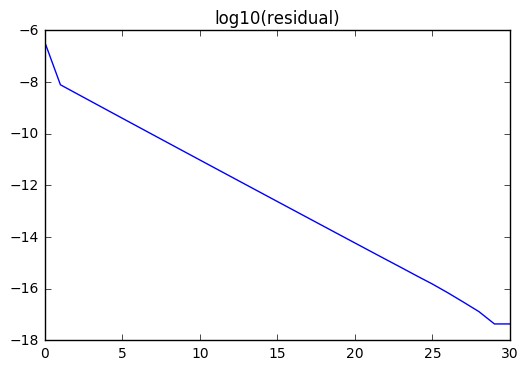

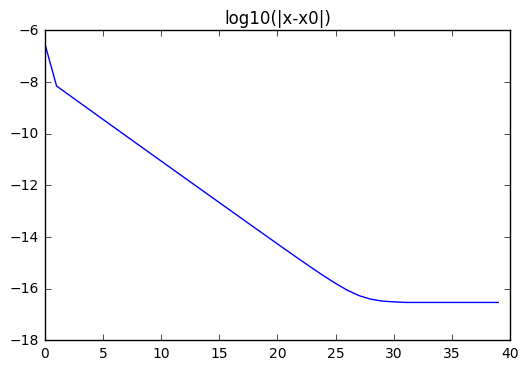

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
global A,B,C,J,N,M


def generate_problem(grid,x):
    global M,N,A,B,C,f0
    f = np.zeros((M,x.shape[1]))
    for i in range(x.shape[1]):
        for j in range(x.shape[0]):
            f[j,i] = np.exp(x[j,i])
    J = np.zeros((M,M,x.shape[1]))
    for i in range(x.shape[1]):
        for j in range(x.shape[0]):
            J[j][j][i] = np.exp(x[j][i])

    _A = A.copy()
    _B = B.copy()
    _C = C.copy()
    while(len(grid) != _A.shape[2]):
        _A = decimation(_A)
        _B = decimation(_B)
        _C = decimation(_C)
    return _A,_B,_C,J,f


def generate_grid(n):
    return np.linspace(0,1,n)

N = 17
M = 3 #in block
np.random.seed(0)
B = np.zeros((M,M,N-1))#np.random.rand(M,M,N)
C = np.zeros((M,M,N-1))#np.random.rand(M,M,N)
C[:,:,0] = 0
A = np.zeros((M,M,N))#np.random.rand(M,M,N)
for i in range(N):
    A[:,:,i] = np.eye(M)

grid = generate_grid(N)
x0 = np.random.rand(M,N).astype(np.float64)
A,B,C,J,f0 = generate_problem(grid,x0)


err = []
ee = []
it = []


x = np.zeros((M,N), dtype=np.float64)
A,B,C,J,f = generate_problem(grid,x)
for i in range(40):
    x = solver(A, B, C, J,f, x, grid, f0)
    A,B,C,J,f = generate_problem(grid,x)
    ee.append(np.abs(f-f0).mean())
    err.append(np.abs(x-x0).mean())
    it.append(i)

plt.title("log10(residual)")
plt.plot(it,np.log10(np.array(ee)))
plt.show()

plt.title("log10(|x-x0|)")
plt.plot(it,np.log10(np.array(err)))
plt.show()